In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
data=pd.read_csv('~\Downloads\daily_data.csv')
data

,datetime,high,low,close,open,volume
0,2018-01-01,13818.55,12750.00,13135.00,13715.65,6970.441076
1,2018-01-02,14750.00,12890.02,14580.00,13135.00,16359.347340
2,2018-01-03,15473.49,14150.00,14749.97,14576.87,19457.238601
3,2018-01-04,15280.00,13918.04,14811.00,14710.00,18783.876561
4,2018-01-05,17118.13,14600.00,16579.00,14805.01,22383.657333
...,...,...,...,...,...,...
1468,2022-01-08,42246.37,40501.00,40679.82,41707.04,27031.900870
1469,2022-01-09,42300.00,40520.00,41966.99,40679.82,27291.009660
1470,2022-01-10,42786.70,39650.00,41604.58,41966.99,51064.904360
1471,2022-01-11,43100.00,41158.99,42755.00,41604.58,38062.818280


In [3]:
def get_macd(price,slow,fast,smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1-exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    frames =  [macd, signal]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

macd=get_macd(data.close,26,12,9)
macd

,macd,signal
0,0.000000,0.000000
1,115.270655,23.054131
2,217.827657,62.008836
3,300.564708,109.720011
4,502.998982,188.375805
...,...,...
1468,-2136.672368,-1568.284564
1469,-2233.642180,-1701.356087
1470,-2313.071268,-1823.699123
1471,-2257.170852,-1910.393469


In [4]:
def generate_signal_for_macd(df,data):
    datetime=[]
    signal=[]
    current=0
    datetime.append(data.datetime[0])
    signal.append(0)
    for i in range(1,len(df.macd)):
        if(df.macd[i]>=df.signal[i] ):
            datetime.append(data.datetime[i])
            signal.append(1)
        elif(df.macd[i]<=df.signal[i]):
            datetime.append(data.datetime[i])
            signal.append(-1)
        else:
            datetime.append(data.datetime[i])
            signal.append(0)
    a=pd.DataFrame(columns=['datetime','signals'])
    a['datetime']=datetime
    a['signals']=signal
    return a
            
        
        
output=generate_signal_for_macd(macd,data)
output

,datetime,signals
0,2018-01-01,0
1,2018-01-02,1
2,2018-01-03,1
3,2018-01-04,1
4,2018-01-05,1
...,...,...
1468,2022-01-08,-1
1469,2022-01-09,-1
1470,2022-01-10,-1
1471,2022-01-11,-1


In [8]:
def static_without_stop_loss(data,output):
    capital=1000
    portfolio_value=[]
    datetime=[]
    quantity=[]
    current=0
    number_of_stock=0
    entry=[]
    exit=[]
    duration=[]
    signal=[]
    current_value=0
    trade_type=[]
    drawdown=[]
    commision_rate=1
    dip=[]
    for i in range(len(output.signals)-1):
        datetime.append(data.datetime[i])
        if(current==0):
            capital=1000
            if(output.signals[i]==0):
                signal.append(0)
                quantity.append(0)
                portfolio_value.append(capital)
                continue
            elif(output.signals[i]==1):
                signal.append(1)
                trade_type.append('long')
                current_value=capital
                portfolio_value.append(capital)
                current=1
                number_of_stock=(capital/data.close[i])
                quantity.append(number_of_stock)
                
                capital=0
                entry.append(i)
            else:
                current_value=capital
                trade_type.append('short')
                signal.append(-1)
                portfolio_value.append(capital)
                current=-1
                number_of_stock=(capital/data.close[i])
                quantity.append(number_of_stock)
                
                capital=2*capital
                entry.append(i)
        elif(current==1):
            if(output.signals[i]==0 or output.signals[i]==1):
                capital=capital+(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                quantity.append(number_of_stock)
                
                    
                signal.append(0)
                capital=capital-(number_of_stock*data.close[i])
                
            
                
            else:
                quantity.append(number_of_stock)
                capital=capital+(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                signal.append(-1)
                
                current=0
                exit.append(i)
                x=entry[-1]
                lambda1=0
                current_max=data.close[x]
                for y in range(x+1,i+1):
                    if(data.close[y]>current_max):
                        current_max=data.close[y]
                    
                    temp=(100*(1-(data.close[y]/current_max)))
                    if(temp>lambda1):
                        lambda1=temp
            
                
                drawdown.append(lambda1)
                dip.append((1000-(np.min(data.close[x:i+1])*number_of_stock))/10)
                number_of_stock=0
                
            
        else:
            quantity.append(number_of_stock)
            if(output.signals[i]==0 or output.signals[i]==-1):
                capital=capital-(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                signal.append(0)
                capital=capital+(number_of_stock*data.close[i])
            else:
                capital=capital-(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                signal.append(1)
                
                current=0
                exit.append(i)
                x=entry[-1]
                lambda1=0
                current_max=data.close[x]
                for y in range(x+1,i+1):
                    if(data.close[y]<current_max):
                        current_max=data.close[y]
                    
                    temp=(100*((data.close[y]/current_max)-1))
                    if(temp>lambda1):
                        lambda1=temp
            
                
                drawdown.append(lambda1)
                dip.append((np.max(data.close[x:i+1])*number_of_stock-1000)/10)
                number_of_stock=0
                          
    a=len(data.datetime)-1
    datetime.append(data.datetime[a])
    quantity.append(number_of_stock)
    if(current==1):
        exit.append(a)
        capital=capital+(number_of_stock*data.close[a])
        signal.append(-1)
        x=entry[-1]
        lambda1=0
        current_max=data.close[x]
        for y in range(x+1,a+1):
            if(data.close[y]>current_max):
                current_max=data.close[y]
                    
            temp=(100*(1-(data.close[y]/current_max)))
            if(temp>lambda1):
                lambda1=temp
            
                
        drawdown.append(lambda1)
        dip.append((1000-(np.min(data.close[x:a+1])*number_of_stock))/10)
    elif(current==-1):
        exit.append(a)
        capital=capital-(number_of_stock*data.close[a])
        signal.append(1)
        x=entry[-1]
        lambda1=0
        current_max=data.close[x]
        for y in range(x+1,a+1):
                
            if(data.close[y]<current_max):
                current_max=data.close[y]
                    
            temp=(100*((data.close[y]/current_max)-1))
            if(temp>lambda1):
                lambda1=temp
                
            
                
        drawdown.append(lambda1)
        dip.append((np.max(data.close[x:i+1])*number_of_stock-1000)/10)
    else:
        signal.append(0)
    portfolio_value.append(capital)
        
        
    
    to_submit=pd.DataFrame(columns=['datetime'])
    to_submit['datetime']=datetime
    to_submit['signals']=signal
    to_submit['open']=data.open
    
    to_submit['high']=data.high
    to_submit['low']=data.low
    to_submit['close']=data.close
    to_submit['volume']=data.volume
    duration=[]
    returns=[]
    PL_in_dollars=[]
    
    
        
    for i in range(len(entry)):
        duration.append(exit[i]-entry[i])
        returns.append(100*((portfolio_value[exit[i]]/portfolio_value[entry[i]])-1))
        PL_in_dollars.append(portfolio_value[exit[i]]-portfolio_value[entry[i]])
        
    trade_wise=pd.DataFrame(columns=['entry','exit','duration','returns'])
    trade_wise['entry']=entry
    trade_wise['exit']=exit
    trade_wise['duration']=duration
    trade_wise['returns']=returns
    trade_wise['type']=trade_type
    trade_wise['drawdown']=drawdown
    
    every_day=pd.DataFrame(columns=['datetime','portfolio value','quantity'])
    every_day['datetime']=datetime
    every_day['portfolio value']=portfolio_value
    every_day['quantity']=quantity
    every_day['daily_return'] = every_day['portfolio value'].pct_change()
    daily_volatility = every_day['daily_return'].std()
    annual_volatility = daily_volatility * math.sqrt(365)
    annual_volatility_negative = every_day[every_day['daily_return'] < 0]['daily_return'].std() * math.sqrt(365)
    risk_free_rate = 0.05
    every_day['excess_return'] = (every_day['daily_return'] - risk_free_rate)
    annual_excess_return = (every_day['daily_return'].mean()*365 - risk_free_rate)
    cumulative_excess_return = every_day['excess_return'].sum()
    negative_returns = [r for r in every_day['excess_return'] if r < 0]
    cumulative_volatility = every_day['daily_return'].std()*math.sqrt(252)
    hello=np.std(negative_returns)*math.sqrt(252)
    sharpe_ratio = annual_excess_return / annual_volatility
    sortino_ratio = annual_excess_return / annual_volatility_negative
                  
    profit=[]
    loss=[]
    for i in range(len(entry)):
        if(returns[i]>=0):
            profit.append(returns[i])
        else:
            loss.append(returns[i])
    
    print("Total Closed trades: ",len(entry))
    print("Winning trades: ",(len(profit)))
    print("Losing Trades: ",(len(entry)-len(profit)))
    number_of_stock=(1000/(data.close[0]))
    bench_mark_return=(number_of_stock)*(data.close[len(data.close)-1])
    bench_mark_return=(bench_mark_return-1000)
    print("Benchmark Return: ",bench_mark_return)
    print("WIN rate: ",(100*len(profit))/len(entry) , " %")
    print("Gross Profit: ",np.sum(PL_in_dollars))
    net_profit=(np.sum(PL_in_dollars)-(len(PL_in_dollars)*(commision_rate)))
    print("Net Profit: ",net_profit)
    print("Average Profit: ",net_profit/(len(PL_in_dollars)))
    print("MAX Drawdowns: ", ((np.max(drawdown)))," %")
    print("Largest Win: ", np.max(profit))
    print("Average Win: ",(np.mean(profit)))
    
   
    print("Largest Loss: ",np.min(loss))
    print("Average Loss: ",np.mean(loss))
    print("Maximum Holding Time: ",np.max(duration))
    print("Average Holding Duration: ",((np.sum(duration))/(len(duration))))
    print("Maximum Dip: ",np.max(dip))
    print("Avg. Dip: ",np.mean(dip))
    print("Sharpe Ratio: ",sharpe_ratio)
    
    print("Sortino Ratio: ", sortino_ratio )
    
   
#     print("returns: ",100*((portfolio_value[-1]/portfolio_value[0])-1)," %")
                  
    plt.plot(portfolio_value)
    
    return to_submit,trade_wise,every_day

Total Closed trades:  90
Winning trades:  39
Losing Trades:  51
Benchmark Return:  2248.9531785306435
WIN rate:  43.333333333333336  %
Gross Profit:  3573.3856537157108
Net Profit:  3483.3856537157108
Average Profit:  38.70428504128567
MAX Drawdowns:  35.07772020725388  %
Largest Win:  53.629871825144406
Average Win:  17.769646753302332
Largest Loss:  -22.671593602848883
Average Loss:  -6.5819148628866655
Maximum Holding Time:  71
Average Holding Duration:  15.355555555555556
Maximum Dip:  22.671593602848883
Avg. Dip:  4.867685335043812
Sharpe Ratio:  0.45236833294193346
Sortino Ratio:  0.5226387651484775


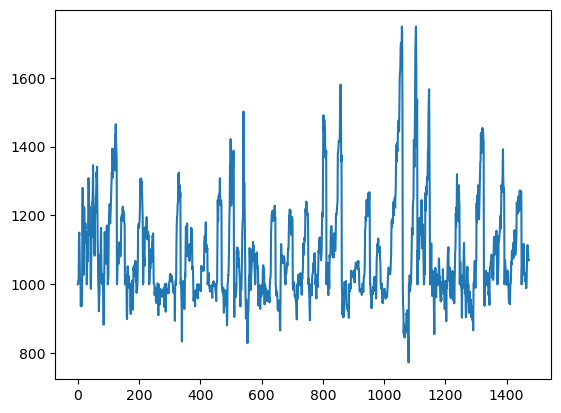

In [9]:
to_submit,trade_wise,every_day=static_without_stop_loss(data,output)

In [10]:
to_submit

,datetime,signals,open,high,low,close,volume
0,2018-01-01,0,13715.65,13818.55,12750.00,13135.00,6970.441076
1,2018-01-02,1,13135.00,14750.00,12890.02,14580.00,16359.347340
2,2018-01-03,0,14576.87,15473.49,14150.00,14749.97,19457.238601
3,2018-01-04,0,14710.00,15280.00,13918.04,14811.00,18783.876561
4,2018-01-05,0,14805.01,17118.13,14600.00,16579.00,22383.657333
...,...,...,...,...,...,...,...
1468,2022-01-08,0,41707.04,42246.37,40501.00,40679.82,27031.900870
1469,2022-01-09,0,40679.82,42300.00,40520.00,41966.99,27291.009660
1470,2022-01-10,0,41966.99,42786.70,39650.00,41604.58,51064.904360
1471,2022-01-11,0,41604.58,43100.00,41158.99,42755.00,38062.818280


In [11]:
trade_wise

,entry,exit,duration,returns,type,drawdown
0,1,10,9,-6.299726,long,18.535542
1,11,28,17,15.115387,short,35.077720
2,29,41,12,17.475647,short,23.825399
3,42,66,24,7.396802,long,20.215156
4,67,81,14,3.064886,short,19.405594
...,...,...,...,...,...,...
85,1393,1408,15,-5.375883,short,13.264893
86,1409,1411,2,-5.782988,long,5.782988
87,1412,1448,36,26.527173,short,8.415702
88,1449,1464,15,-1.120804,long,11.492766


In [12]:
every_day

,datetime,portfolio value,quantity,daily_return,excess_return
0,2018-01-01,1000.000000,0.000000,NaN,NaN
1,2018-01-02,1000.000000,0.068587,0.000000,-0.050000
2,2018-01-03,1011.657750,0.068587,0.011658,-0.038342
3,2018-01-04,1015.843621,0.068587,0.004138,-0.045862
4,2018-01-05,1137.105624,0.068587,0.119371,0.069371
...,...,...,...,...,...
1468,2022-01-08,1114.113875,0.021777,0.020502,-0.029498
1469,2022-01-09,1086.083120,0.021777,-0.025160,-0.075160
1470,2022-01-10,1093.975338,0.021777,0.007267,-0.042733
1471,2022-01-11,1068.922594,0.021777,-0.022901,-0.072901
